# EmotionNet - Multi Modal Emotion Recognition

In [7]:
# importing all libraries
import numpy as np
import os
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt

## Loading the Data

In [8]:

# train and test data for audio features
train_x = pickle.load(open('./non_redundant_train_mfcc_features_0.pickle', 'rb'))
test_x = pickle.load(open('./non_redundant_test_mfcc_features_0.pickle', 'rb'))

#train and test labels for audio features
train_y = pickle.load(open('./non_redundant_training_labels_flattened_2d.pickle', 'rb'))
test_y = pickle.load(open('./non_redundant_test_labels_flattened_2d.pickle', 'rb'))

#train and test labels for image features
img_train_y_ = pickle.load(open('non_redundant_training_labels_flattened_3d.pickle', 'rb'))
img_test_y_ = pickle.load(open('non_redundant_test_labels_flattened_3d.pickle', 'rb'))

# train and test data for image features
img_train = pickle.load(open('./non_redundant_training_features_flattened_3d.pickle', 'rb'))
img_test = pickle.load(open('./non_redundant_test_features_flattened_3d.pickle', 'rb'))

In [9]:
img_train[0].shape

(12288,)

In [10]:
# printing a couple of relevant shapes ->

In [11]:
train_x[0].shape

(299, 13)

In [12]:
len(train_x)

1200

In [13]:
len(train_y)

1200

In [14]:
len(img_train_y_)

1200

In [15]:
np.array(img_train).shape

(1200,)

In [16]:
img_train[0].shape

(12288,)

In [17]:
train_x[0].flatten().shape

(3887,)

In [18]:
len(train_y)

1200

In [19]:
len(test_y)

240

## Data Preprocessing for Audio and Image features

In [20]:
#creating empty arrays for appending transformed data
audio_train_x = []
audio_train_y = []
audio_test_x = []
audio_test_y = []


#converting audio train_x to a suitable format
for i in range(len(train_x)):
    
    #flattening the individual data point
    feat = train_x[i].flatten()
    
    #checking shape
    if(feat.shape[0]==3887):
        #appending
        audio_train_x.append(feat)
        
        #subtracting 1 for ensuring zero based indexing of train output labels
        audio_train_y.append(train_y[i]-1)
    else:
        #appending zeros otherwise
        audio_train_x.append(np.zeros(3887))

#doing same for test data (no labels though, obviously)
for i in range(len(test_x)):
    feat = test_x[i].flatten()
    audio_test_x.append(feat)
    audio_test_y.append(test_y[i]-1)

In [21]:
# creating a suitably shaped numpy array from  transformed data

# train shape - > 1200 x 3887
audio_train_x = np.asarray(audio_train_x).reshape((len(audio_train_x), 3887))
# test shape - > 240 x 3887
audio_test_x = np.asarray(audio_test_x).reshape((len(audio_test_x), 3887))

# scaling the data
audio_train_x = preprocessing.scale(audio_train_x)
audio_test_x = preprocessing.scale(audio_test_x)

print(audio_train_x.shape, audio_test_x.shape)

(1200, 3887) (240, 3887)


C:\Users\manavgakhar\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [22]:
len(img_train[0])

12288

In [23]:
4*2048

8192

In [24]:
# we need 1200 x 8192 dimensional flattened vectors for training
img_train_x = np.zeros((len(img_train), 4*2048))
img_train_y = []


for i, feat in enumerate(img_train):
    #getting first 8192 elements
    feat = feat[:int(img_train_x.shape[1])]
    #putting the value in the modified img_train
    img_train_x[i] = feat
    #subtracting one for zero based indexing of labels
    img_train_y.append(img_train_y_[i]-1)
    
    img_test_x = np.zeros((len(img_test), 4*2048))

# Doing the same for test data
img_test_y = []

for i, feat in enumerate(img_test):
    #getting first 8192 elements
    feat = feat[:int(img_test_x.shape[1])]
    #putting the value in the modified img_train
    img_test_x[i] = feat
     #subtracting one for zero based indexing of labels
    img_test_y.append(img_test_y_[i]-1)

#scaling the train and test images
img_train_x = preprocessing.scale(img_train_x)
img_test_x = preprocessing.scale(img_test_x)

print(img_train_x.shape, img_test_x.shape)

(1200, 8192) (240, 8192)


## Trying out ML algorithms for emotion prediction purely on the basis of audio features

In [25]:
#assigning new variables to audio train and test data
train_x = audio_train_x
test_x = audio_test_x

# assigning new variables to labels
labs = img_train_y
test_labs = img_test_y

# Using SVM for predicting emotion based on only audio features
svm = SVC(gamma='auto')
svm.fit(train_x, labs)

print("SVM Train Accuracy: ",accuracy_score(labs, svm.predict(train_x)))
print("SVM Test Accuracy: ",accuracy_score(test_labs, svm.predict(test_x)))

SVM Train Accuracy:  0.9141666666666667
SVM Test Accuracy:  0.13333333333333333


In [26]:
# Using Logistic Regression for predicting emotion based on only audio features
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_x, labs)

print("Logistic Regression Train Accuracy: ",accuracy_score(labs, log_reg.predict(train_x)))
print("Logistic Regression Test Accuracy: ",accuracy_score(test_labs, log_reg.predict(test_x)))

Logistic Regression Train Accuracy:  0.9991666666666666
Logistic Regression Test Accuracy:  0.14583333333333334


In [27]:
# Using Decision Tree for predicting emotion based on only audio features
dt = tree.DecisionTreeClassifier()
dt.fit(train_x, labs)

print("Decision Tree Train Accuracy: ",accuracy_score(labs, dt.predict(train_x)))
print("Decision Tree Test Accuracy: ",accuracy_score(test_labs, dt.predict(test_x)))

Decision Tree Train Accuracy:  0.9991666666666666
Decision Tree Test Accuracy:  0.1125


In [28]:
# Using Random Forest for predicting emotion based on only audio features
rf = RandomForestClassifier()
rf.fit(train_x, labs)

print("Random Forest Train Accuracy: ",accuracy_score(labs, rf.predict(train_x)))
print("Random Forest Test Accuracy: ",accuracy_score(test_labs, rf.predict(test_x)))

Random Forest Train Accuracy:  0.9991666666666666
Random Forest Test Accuracy:  0.125


### MLP model for Audio 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import math

class Classification_Net(nn.Module):
    def __init__(self, input_dims=3887):
        super(Classification_Net, self).__init__()
        self.fc1 = nn.Linear(input_dims, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, feats):
        concat_vector = feats
        out1 = self.dropout_5(self.relu(self.fc1(concat_vector)))
        out2 = self.dropout_2(self.relu(self.fc2(out1)))
        out3 = self.dropout_2(self.relu(self.fc3(out2)))
        out4 = self.fc4(out3)
        return out4

from torch.utils.data import *

train_tensor_x = torch.Tensor(audio_train_x)
train_tensor_y = torch.Tensor(labs)
test_tensor_x = torch.Tensor(audio_test_x)
test_tensor_y = torch.Tensor(test_labs)

train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

model = Classification_Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

losses = []
val_accs = []
train_accs = []

for epoch in range(50):
      for itr, (x, y) in enumerate(train_dataloader):
      
        outputs = model(x)
        loss = criterion(outputs, y.long())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        if(itr%100 == 0):
          with torch.no_grad():
            train_correct = 0
            train_total = 0
            val_correct = 0
            val_total = 0

            train_preds = []
            train_gts = []
            test_preds = []
            test_gts = []

            for x, y in test_dataloader:
            

              outputs = model(x)

              _, predicted = torch.max(outputs.data, 1)
              val_total += y.size(0)
              val_correct += (predicted == y.long()).sum().item()

              test_preds += list(predicted.cpu().detach().numpy())
              test_gts += list(y.cpu().detach().numpy())

            for i, (x, y) in enumerate(train_dataloader):
              if(i == 50):
                break
            

              outputs = model(x)

              _, predicted = torch.max(outputs.data, 1)
              train_total += y.size(0)
              train_correct += (predicted == y.long()).sum().item()

              train_preds += list(predicted.cpu().detach().numpy())
              train_gts += list(y.cpu().detach().numpy())              
              
            train_precision = precision_score(train_gts, train_preds, average='micro')
            train_recall = recall_score(train_gts, train_preds, average='micro')
            test_precision = precision_score(test_gts, test_preds, average='micro')
            test_recall = recall_score(test_gts, test_preds, average='micro')

            print('Epoch: '+str(epoch)+', Itr: '+str(itr)+', Loss: '+str(loss.item())+', Val acc: '+str(100 * val_correct/val_total)+', Train acc: '+str(100 * train_correct/train_total))
            print('TrainP: '+str(train_precision)+', TrainR: '+str(train_recall)+', TestP: '+str(test_precision)+', TestR: '+str(test_recall))
            losses.append(loss.item())
            val_accs.append(100 * val_correct/val_total)
            train_accs.append(100 * train_correct/train_total)
plt.figure()
plt.plot(losses)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.savefig('unimodal_audio_loss.png')

plt.figure()
plt.plot(val_accs, label='Test')
plt.plot(train_accs, label='Train')
plt.title('Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc='best')
plt.savefig('unimodal_audio_acc.png')

## Trying out ML algorithms for emotion prediction purely on the basis of image features

In [ ]:
#assigning new variables to audio train and test data
train_x = img_train_x
test_x = img_test_x

# assigning new variables to labels
labs = img_train_y
test_labs = img_test_y

# Using SVM for predicting emotion based on only image features
svm = SVC(gamma='auto')
svm.fit(train_x, labs)

print("SVM Train Accuracy: ",accuracy_score(labs, svm.predict(train_x)))
print("SVM Test Accuracy: ",accuracy_score(test_labs, svm.predict(test_x)))

In [ ]:
# Using Logistic Regression for predicting emotion based on only image features
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_x, labs)

print("Logistic Regression Train Accuracy: ",accuracy_score(labs, log_reg.predict(train_x)))
print("Logistic Regression Test Accuracy: ",accuracy_score(test_labs, log_reg.predict(test_x)))

In [ ]:
# Using Decision Tree for predicting emotion based on only image features
dt = tree.DecisionTreeClassifier()
dt.fit(train_x, labs)

print("Decision Tree Train Accuracy: ",accuracy_score(labs, dt.predict(train_x)))
print("Decision Tree Test Accuracy: ",accuracy_score(test_labs, dt.predict(test_x)))

In [ ]:
# Using Random Forest for predicting emotion based on only image features
rf = RandomForestClassifier()
rf.fit(train_x, labs)

print("Random Forest Train Accuracy: ",accuracy_score(labs, rf.predict(train_x)))
print("Random Forest Test Accuracy: ",accuracy_score(test_labs, rf.predict(test_x)))

### MLP model for image 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import math

class Classification_Net(nn.Module):
    def __init__(self, input_dims=8192):
        super(Classification_Net, self).__init__()
        self.fc1 = nn.Linear(input_dims, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, feats):
        concat_vector = feats
        out1 = self.dropout_5(self.relu(self.fc1(concat_vector)))
        out2 = self.dropout_2(self.relu(self.fc2(out1)))
        out3 = self.dropout_2(self.relu(self.fc3(out2)))
        out4 = self.fc4(out3)
        return out4

from torch.utils.data import *

train_tensor_x = torch.Tensor(img_train_x)
train_tensor_y = torch.Tensor(img_train_y)
test_tensor_x = torch.Tensor(img_test_x)
test_tensor_y = torch.Tensor(img_test_y)

print(train_tensor_x.shape, train_tensor_y.shape, test_tensor_x.shape, test_tensor_y.shape)

train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

model = Classification_Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')


losses = []
val_accs = []
train_accs = []

for epoch in range(50):
      for itr, (x, y) in enumerate(train_dataloader):
        outputs = model(x)
        loss = criterion(outputs, y.long())

      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        if(itr%100 == 0):
          with torch.no_grad():
            train_correct = 0
            train_total = 0
            val_correct = 0
            val_total = 0

            train_preds = []
            train_gts = []
            test_preds = []
            test_gts = []            

            for x, y in test_dataloader:
              
              outputs = model(x)

              _, predicted = torch.max(outputs.data, 1)
              val_total += y.size(0)
              val_correct += (predicted == y.long()).sum().item()

              test_gts += list(y.cpu().detach().numpy())
              test_preds += list(predicted.cpu().detach().numpy())              

            for i, (x, y) in enumerate(train_dataloader):
              if(i == 50):
                break
              

              outputs = model(x)

              _, predicted = torch.max(outputs.data, 1)
              train_total += y.size(0)
              train_correct += (predicted == y.long()).sum().item()

              train_gts += list(y.cpu().detach().numpy())
              train_preds += list(predicted.cpu().detach().numpy())

            train_precision = precision_score(train_gts, train_preds, average='micro')
            train_recall = recall_score(train_gts, train_preds, average='micro')
            test_precision = precision_score(test_gts, test_preds, average='micro')
            test_recall = recall_score(test_gts, test_preds, average='micro')

            print('Epoch: '+str(epoch)+', Itr: '+str(itr)+', Loss: '+str(loss.item())+', Val acc: '+str(100 * val_correct/val_total)+', Train acc: '+str(100 * train_correct/train_total))
            print('TrainP: '+str(train_precision)+', TrainR: '+str(train_recall)+', TestP: '+str(test_precision)+', TestR: '+str(test_recall))              
            losses.append(loss.item())
            val_accs.append(100 * val_correct/val_total)
            train_accs.append(100 * train_correct/train_total)
#           
torch.save(model.state_dict(), 'model_concat_16384_dimensional.ckpt')

plt.figure()
plt.plot(losses)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.savefig('unimodal_img_loss.png')

plt.figure()
plt.plot(val_accs, label='Test')
plt.plot(train_accs, label='Train')
plt.title('Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc='best')
plt.savefig('unimodal_img_acc.png')

# Hybrid Fusion Model which combines Audio and Image Features

# 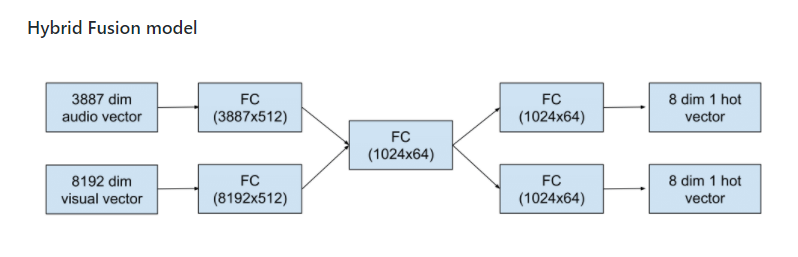

In [35]:
class audioAndImageDataset():
    def __init__(self, data, labels):
        self.img_data = data[0]
        self.audio_data = data[1]
        self.img_labels = labels[0]
        self.audio_labels = labels[1]

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.img_data[idx]
        img_l = self.img_labels[idx]
        audio = self.audio_data[idx]
        audio_l = self.audio_labels[idx]

        return ([img, audio], [img_l, audio_l])

class Concat_Net_2(nn.Module):
    # passing respective img and audio feature dimension as default parameter values i.e 8192 and 3887 respectively
    def __init__(self, img_input_dims=8192, audio_input_dims=3887):
        # calling the super constructor
        super(Concat_Net_2, self).__init__()
        # first fully connected N.N layer of audio pipeline
        # 512 nodes
        self.fc1 = nn.Linear(audio_input_dims, 512)
        # first fully connected N.N layer of image pipeline
        # 512 nodes
        self.fc2 = nn.Linear(img_input_dims, 512)
        # Concatenating the two pipelines in the third N.N layers
        # 128 nodes
        self.fc3 = nn.Linear(512*2, 128)
        # fourth N.N layer of 64 nodes
        self.fc4 = nn.Linear(128, 64)
        # audio output branch after 4th layer
        self.fc5_audio = nn.Linear(64, 8)
        # image output branch after 4th layer
        self.fc5_img = nn.Linear(64, 8)
        # Dropout layer for regularisation
        self.dropout_2 = nn.Dropout(p=0.2)
        # Dropout layer for regularisation
        self.dropout_5 = nn.Dropout(p=0.5)
        # ReLU activation layer
        self.relu = nn.ReLU()
    # forward pass function
    def forward(self, img_feats, audio_feats):
        
        #image pipeline branch - 1st F.C layer
        out_img1 = self.dropout_5(self.relu(self.fc2(img_feats.float())))
        
        #audio pipeline branch - 1st F.C layer
        out_audio1 = self.dropout_5(self.relu(self.fc1(audio_feats.float())))
        
        #concatenating the two pipeline branches (audio and video)
        concat_vector = torch.cat((out_img1, out_audio1), dim=1)
        
        #concat branch has a layer with 128 nodes
        out2 = self.dropout_2(self.relu(self.fc3(concat_vector)))
        
        #finally passing it to the 64 node layer before output layer
        out3 = self.dropout_2(self.relu(self.fc4(out2)))
        
        #image and audio outputs
        out_img = self.fc5_img(out3)
        out_audio = self.fc5_audio(out3)
        
        #returning both
        return out_img, out_audio

from torch.utils.data import *



#train and test data for audio and video
train_data = [img_train_x, audio_train_x]
train_labels = [img_train_y, img_train_y]
test_data = [img_test_x, audio_test_x]
test_labels = [img_test_y, img_test_y]

# transforming data
train_dataset = audioAndImageDataset(train_data, train_labels)
test_dataset = audioAndImageDataset(test_data, test_labels)

# using data loader with b.s -> 128
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)



In [43]:
count=0
for (x,y) in train_dataloader:
    if(count==0):
        print(x,y)
        print(x[0].shape,x[1].shape)
        print(y[0].shape,y[1].shape)
    count+=1

[tensor([[-0.2471, -0.7980, -1.0642,  ...,  0.5162, -1.1838, -0.2612],
        [ 1.7340,  0.1549, -0.0909,  ...,  0.0026, -0.0823, -1.3763],
        [-0.9484, -0.4036, -1.0581,  ...,  0.1762, -0.9403, -0.9638],
        ...,
        [-0.2471,  0.2586,  1.6709,  ..., -0.3474, -0.6068,  1.8688],
        [-0.4608, -0.7491,  1.1422,  ..., -1.1580, -0.7595, -1.3892],
        [-0.1543, -0.6652,  1.5559,  ...,  1.0713,  0.3031, -1.4219]],
       dtype=torch.float64), tensor([[-0.2242,  0.2173,  0.1648,  ..., -0.2115,  1.1244,  0.3602],
        [-0.2242,  0.2173,  0.1648,  ...,  0.1670,  0.3218, -0.9088],
        [-0.2242,  0.2173,  0.1648,  ..., -0.3349,  0.2425, -0.7148],
        ...,
        [-0.2242,  0.2173,  0.1648,  ..., -0.0519,  0.6318,  0.0551],
        [-0.2242,  0.2173,  0.1648,  ...,  0.0809, -0.1191, -0.3431],
        [-0.2242,  0.2173,  0.1648,  ...,  1.2940, -0.0347,  0.1691]],
       dtype=torch.float64)] [tensor([3, 0, 7, 2, 5, 6, 1, 5, 0, 6, 1, 0, 5, 2, 3, 1, 0, 3, 4, 6, 4, 7

In [50]:
model = Concat_Net_2()
#CrossEntropy loss
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')



# arrays for loss, train_acc, and test_acc
losses = []
img_train_acc = []
img_test_acc = []
audio_train_acc = []
audio_test_acc = []


#running model for 50 epochs
for epoch in range(50):
    
      for itr, (x, y) in enumerate(train_dataloader):
        # here number of itr is dataset_size/batch_size
        
        # getting outputs from the model
        outputs_img, outputs_audio = model(x[0], x[1])
        #getting loss -> adding audio and image losses
        loss = criterion(outputs_audio, y[1].long()) + criterion(outputs_img, y[0].long())
        
        #making gradient zero again
        optimizer.zero_grad()
        #backpropagating loss
        loss.backward()
        #taking a grad. desc. step (updating weights)
        optimizer.step() 

        
        if(itr%100 == 0):
            
            # for every 100th iterat
            with torch.no_grad():
                train_correct_img = 0
                train_total_img = 0
                val_correct_img = 0
                val_total_img = 0
                train_correct_audio = 0
                train_total_audio = 0
                val_correct_audio = 0
                val_total_audio = 0

                img_train_preds = []
                img_train_gts = []
                img_test_preds = []
                img_test_gts = []            
                audio_train_preds = []
                audio_train_gts = []
                audio_test_preds = []
                audio_test_gts = []

                for x, y in test_dataloader:
                 
                    
                    #outputs on test
                    outputs_img, outputs_audio = model(x[0], x[1])

                    # acts like argmax
                    _, predicted_img = torch.max(outputs_img.data, 1)
                    #
                    
                    
                    # batch size of 64 so it returns 63
                    val_total_img += y[0].size(0)
                    
                    #converting to long datatype, then summing all the True (1s), then use .item() to get the images
                    val_correct_img += (predicted_img == y[0].long()).sum().item()
                    
                    
                    _, predicted_audio = torch.max(outputs_audio.data, 1)
                    val_total_audio += y[1].size(0)
                    val_correct_audio += (predicted_audio == y[1].long()).sum().item()
                    
                    # tensors are attached to gpu so to convert to it numpy we send it to cpu
                    
                    #img test ground truths
                    img_test_gts += list(y[0].cpu().detach().numpy())
                    #img_test preds
                    img_test_preds += list(predicted_img.cpu().detach().numpy())      
                    # same for audio
                    audio_test_gts += list(y[1].cpu().detach().numpy())
                    audio_test_preds += list(predicted_audio.cpu().detach().numpy())
                
                
                # now evaluating on training data 
                for i, (x, y) in enumerate(train_dataloader):
                    if(i == 50):
                        break
                
                    
                    
                    # same flow as done above for test_dataloader
                    outputs_img, outputs_audio = model(x[0], x[1])

                    _, predicted_img = torch.max(outputs_img.data, 1)
                    train_total_img += y[0].size(0)
                    train_correct_img += (predicted_img == y[0].long()).sum().item()

                    _, predicted_audio = torch.max(outputs_audio.data, 1)
                    train_total_audio += y[1].size(0)
                    train_correct_audio += (predicted_audio == y[1].long()).sum().item()

                    img_train_gts += list(y[0].cpu().detach().numpy())
                    img_train_preds += list(predicted_img.cpu().detach().numpy())              
                    audio_train_gts += list(y[1].cpu().detach().numpy())
                    audio_train_preds += list(predicted_audio.cpu().detach().numpy())
                
                # micro average helps as dataset varies in size
                img_train_precision = precision_score(img_train_gts, img_train_preds, average='micro')
                img_train_recall = recall_score(img_train_gts, img_train_preds, average='micro')
                img_test_precision = precision_score(img_test_gts, img_test_preds, average='micro')
                img_test_recall = recall_score(img_test_gts, img_test_preds, average='micro')
                audio_train_precision = precision_score(audio_train_gts, audio_train_preds, average='micro')
                audio_train_recall = recall_score(audio_train_gts, audio_train_preds, average='micro')
                audio_test_precision = precision_score(audio_test_gts, audio_test_preds, average='micro')
                audio_test_recall = recall_score(audio_test_gts, audio_test_preds, average='micro')
            
                print('Epoch: '+str(epoch)+', Itr: '+str(itr)+', Loss: '+str(loss.item())+', Val img acc: '+ str(100 * val_correct_img/val_total_img)+', Train img acc: '+ str(100 * train_correct_img/train_total_img)+', Val audio acc: '+str(100 * val_correct_audio/val_total_audio)+', Train audio acc: '+str(100 * train_correct_audio/train_total_audio))
                print('ImgTrainP: '+str(img_train_precision)+', ImgTrainR: '+str(img_train_recall)+', ImgTestP: '+str(img_test_precision)+', ImgTestR: '+str(img_test_recall))              
                print('AudioTrainP: '+str(audio_train_precision)+', AudioTrainR: '+str(audio_train_recall)+', AudioTestP: '+str(audio_test_precision)+', AudioTestR: '+str(audio_test_recall))
                losses.append(loss.item())
                audio_test_acc.append(100*val_correct_audio/val_total_audio)
                audio_train_acc.append(100*train_correct_audio/train_total_audio)
                img_test_acc.append(100*val_correct_img/val_total_img)
                img_train_acc.append(100*train_correct_img/train_total_img)   
             

Epoch: 0, Itr: 0, Loss: 4.187384605407715, Val img acc: 13.975694444444445, Train img acc: 16.05902777777778, Val audio acc: 14.930555555555555, Train audio acc: 14.67013888888889
ImgTrainP: 0.1605902777777778, ImgTrainR: 0.1605902777777778, ImgTestP: 0.13975694444444445, ImgTestR: 0.13975694444444445
AudioTrainP: 0.1467013888888889, AudioTrainR: 0.1467013888888889, AudioTestP: 0.14930555555555555, AudioTestR: 0.14930555555555555
Epoch: 1, Itr: 0, Loss: 3.4246459007263184, Val img acc: 36.02430555555556, Train img acc: 37.760416666666664, Val audio acc: 38.107638888888886, Train audio acc: 38.107638888888886
ImgTrainP: 0.3776041666666667, ImgTrainR: 0.3776041666666667, ImgTestP: 0.3602430555555556, ImgTestR: 0.3602430555555556
AudioTrainP: 0.3810763888888889, AudioTrainR: 0.3810763888888889, AudioTestP: 0.3810763888888889, AudioTestR: 0.3810763888888889
Epoch: 2, Itr: 0, Loss: 2.967071533203125, Val img acc: 48.4375, Train img acc: 50.173611111111114, Val audio acc: 46.44097222222222, 

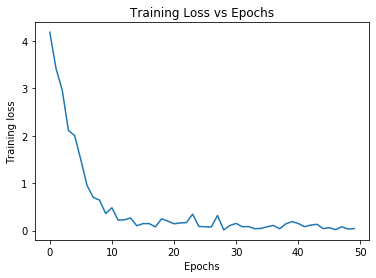

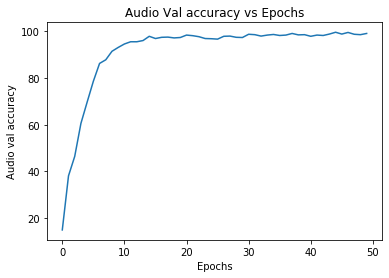

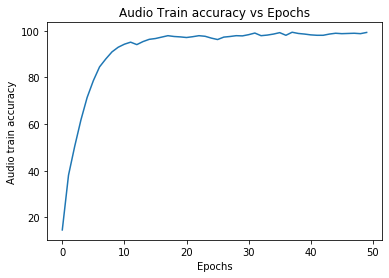

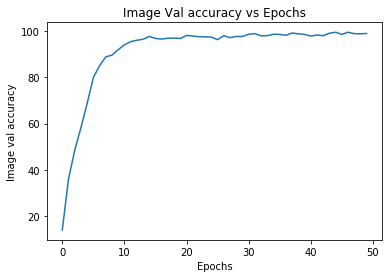

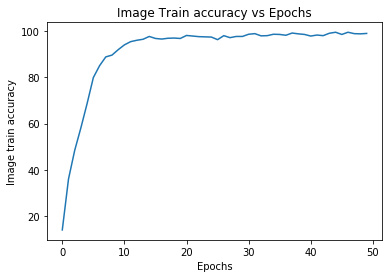

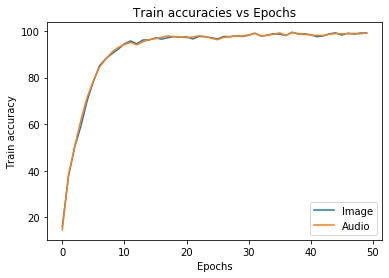

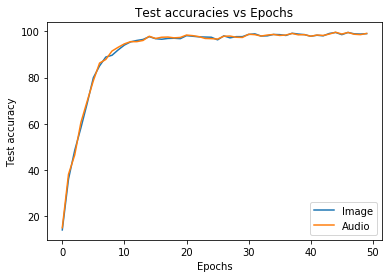

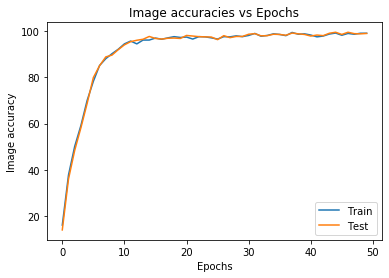

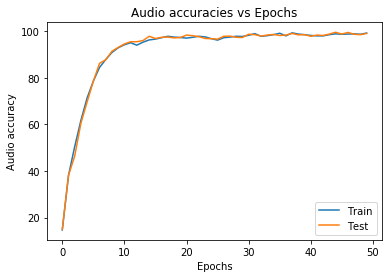

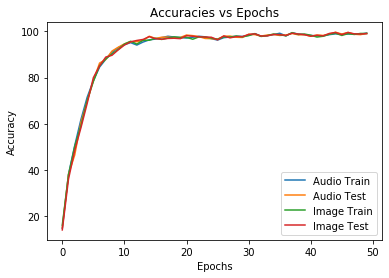

In [51]:
plt.figure()
plt.plot(losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss')


plt.figure()
plt.plot(audio_test_acc)
plt.title('Audio Val accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Audio val accuracy')


plt.figure()
plt.plot(audio_train_acc)
plt.title('Audio Train accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Audio train accuracy')


plt.figure()
plt.plot(img_test_acc)
plt.title('Image Val accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Image val accuracy')


plt.figure()
plt.plot(img_test_acc)
plt.title('Image Train accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Image train accuracy')

plt.figure()
plt.plot(img_train_acc, label='Image')
plt.plot(audio_train_acc, label='Audio')
plt.title('Train accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train accuracy')
plt.legend(loc='best')


plt.figure()
plt.plot(img_test_acc, label='Image')
plt.plot(audio_test_acc, label='Audio')
plt.title('Test accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.legend(loc='best')


plt.figure()
plt.plot(img_train_acc, label='Train')
plt.plot(img_test_acc, label='Test')
plt.title('Image accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Image accuracy')
plt.legend(loc='best')


plt.figure()
plt.plot(audio_train_acc, label='Train')
plt.plot(audio_test_acc, label='Test')
plt.title('Audio accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Audio accuracy')
plt.legend(loc='best')


plt.figure()
plt.plot(audio_train_acc, label='Audio Train')
plt.plot(audio_test_acc, label='Audio Test')
plt.plot(img_train_acc, label='Image Train')
plt.plot(img_test_acc, label='Image Test')
plt.title('Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
